## 1. Initialize

### 1.1 Import libraries

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.utils import save_image
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Resize, Compose, RandomRotation, RandomPerspective, ColorJitter
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from torch import optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
# Defining augmentation transform for Datasets
augmentation_transforms = Compose([
    RandomRotation(degrees=5),              # Random rotation upto 5 degrees
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)   # Color jitter
])

### 1.2 GTSRB Dataset

In [ ]:
gtsrb_label_map = {
    '0': '20_speed',
    '2': '50_speed',
    '1': '30_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

In [ ]:
prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16] #(circular, white ground with red border)
mandatory = [33, 34, 35, 36, 37, 38, 39, 40] #(circular, blue ground)
danger = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] #(triangular, white ground with red border)

In [ ]:
gtsrb_training_data = datasets.GTSRB(root="data", split="train", download=True, transform=Compose([ToTensor(),Resize(size=(48,48))]))
gtsrb_test_data = datasets.GTSRB(root="data", split="test", download=True, transform=Compose([ToTensor(),Resize(size=(48,48))]))

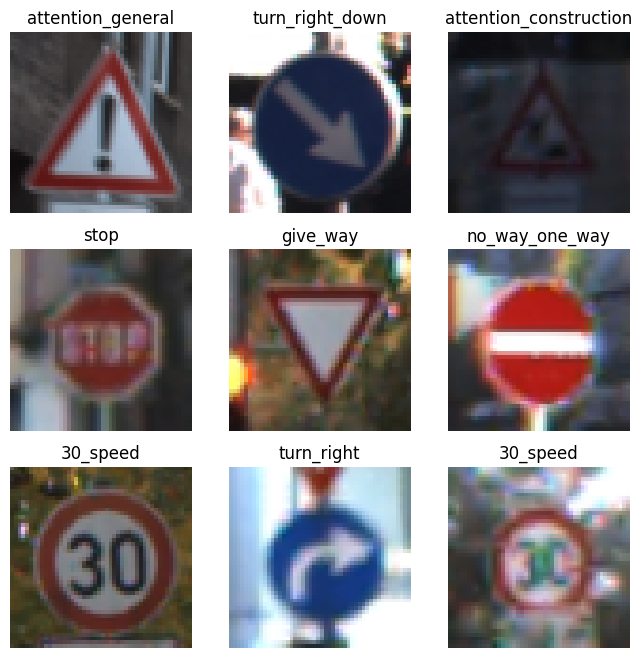

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gtsrb_training_data), size=(1,)).item()
    img, label = gtsrb_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(gtsrb_label_map[f'{label}'])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)), cmap="gray")
plt.show()

1. Not detecting STOP sign
2. Not detecting YIELD sign
3. Changing the speed limit eg 30 to 80
4. Changing the unit of speed limit
5. Right turn only to no right turn or vice a versa
6. Optional movement lane control, straight through and left turn to leftr turn or vice a versa

### 1.3 GTSRB Augmented Dataset

In [ ]:
gtsrb_aug_training_data = datasets.GTSRB(root="data", split="train", download=True, transform=Compose([augmentation_transforms, ToTensor(), Resize(size=(48,48))]))
gtsrb_aug_test_data = datasets.GTSRB(root="data", split="test", download=True, transform=Compose([ToTensor(),Resize(size=(48,48))]))

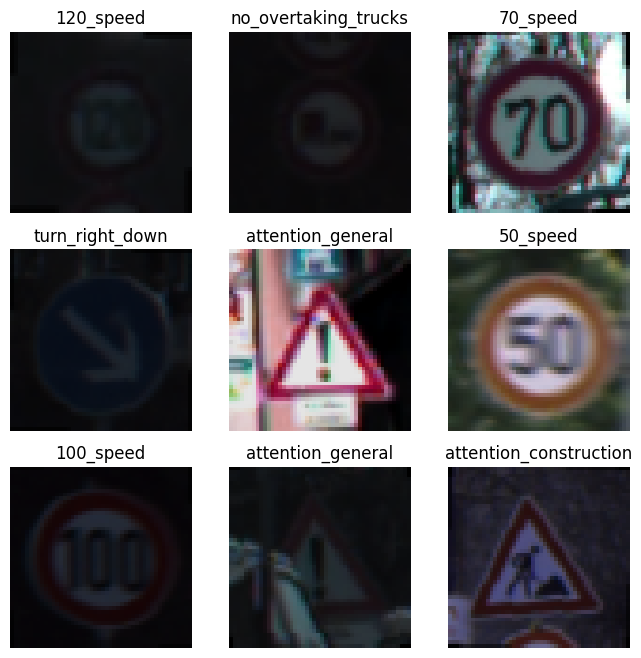

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gtsrb_aug_training_data), size=(1,)).item()
    img, label = gtsrb_aug_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(gtsrb_label_map[f'{label}'])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)), cmap="gray")
plt.show()

### 1.4 LISA Dataset

In [ ]:
lisa_map_label = {
    'addedLane':'0',
    'curveLeft':'1',
    'curveRight':'2',
    'dip':'3',
    'doNotEnter':'4',
    'doNotPass':'5',
    'intersection':'6',
    'keepRight':'7',
    'laneEnds':'8',
    'merge':'9',
    'noLeftTurn':'10',
    'noRightTurn':'11',
    'pedestrianCrossing':'12',
    'rampSpeedAdvisory20':'13',
    'rampSpeedAdvisory35':'14',
    'rampSpeedAdvisory40':'15',
    'rampSpeedAdvisory45':'16',
    'rampSpeedAdvisory50':'17',
    'rampSpeedAdvisoryUrdbl':'18',
    'rightLaneMustTurn':'19',
    'roundabout':'20',
    'school':'21',
    'schoolSpeedLimit25':'22',
    'signalAhead':'23',
    'slow':'24',
    'speedLimit15':'25',
    'speedLimit25':'26',
    'speedLimit30':'27',
    'speedLimit35':'28',
    'speedLimit40':'29',
    'speedLimit45':'30',
    'speedLimit50':'31',
    'speedLimit55':'32',
    'speedLimit65':'33',
    'speedLimitUrdbl':'34',
    'stop':'35',
    'stopAhead':'36',
    'thruMergeLeft':'37',
    'thruMergeRight':'38',
    'thruTrafficMergeLeft':'39',
    'truckSpeedLimit55':'40',
    'turnLeft':'41',
    'turnRight':'42',
    'yield':'43',
    'yieldAhead':'44',
    'zoneAhead25':'45',
    'zoneAhead45':'46'
}

In [ ]:
lisa_label_map = {v:k for k, v in lisa_map_label.items()}

In [ ]:
class LISADataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.images = os.listdir(path)
    def __getitem__(self, index):
        img_name = os.path.join(self.path, self.images[index])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        label = int(lisa_map_label[self.images[index].split('_')[1][:-4]])
        return image, label
    def __len__(self):
        return len(self.images)

In [ ]:
lisa_training_data = LISADataset(path="./data/LISA/training", transform=Compose([ToTensor(),Resize(size=(48,48))]))
lisa_test_data = LISADataset(path="./data/LISA/testing", transform=Compose([ToTensor(),Resize(size=(48,48))]))

FileNotFoundError: [Errno 2] No such file or directory: './data/LISA/training'

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(lisa_training_data), size=(1,)).item()
    img, label = lisa_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(lisa_label_map[f'{label}'])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)), cmap="gray")
plt.show()

### 1.5 LISA Augmented Dataset

In [ ]:
lisa_aug_training_data = LISADataset(path="./data/LISA/training", transform=Compose([augmentation_transforms, ToTensor(), Resize(size=(48,48))]))
lisa_aug_test_data = LISADataset(path="./data/LISA/training", transform=Compose([ToTensor(),Resize(size=(48,48))]))

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(lisa_aug_training_data), size=(1,)).item()
    img, label = lisa_aug_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(lisa_label_map[f'{label}'])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)), cmap="gray")
plt.show()

## 2. Traffic Sign Recognition Model Training

### 2.1 Train and Test Functions

In [ ]:
# Set batch size
batch_size = 64

# Get cuda, mps or resort to cpu.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute loss
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### 2.2 Model CNN

#### 2.2.1 Model Definition

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=43):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(18432,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512,out_channels),
            nn.Softmax()
        )
    def forward(self, x):
        y = self.cnn(x)
        return y

#### 2.2.2 GTSRB-CNN Model Training

In [ ]:
train_dataloader = DataLoader(gtsrb_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
model = CNN(in_channels=3, out_channels=n_labels).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=18432, out_features=512, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.5, inplace=False)
    (

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


loss: 3.764062  [   64/26640]
loss: 3.011360  [ 6464/26640]
loss: 2.882854  [12864/26640]
loss: 2.814477  [19264/26640]
loss: 2.851642  [25664/26640]
Test Error: 
 Accuracy: 95.1%, Avg loss: 2.869998 

Epoch 2
-------------------------------
loss: 2.816353  [   64/26640]
loss: 2.805165  [ 6464/26640]
loss: 2.804631  [12864/26640]
loss: 2.816896  [19264/26640]
loss: 2.807048  [25664/26640]
Test Error: 
 Accuracy: 96.0%, Avg loss: 2.853408 

Epoch 3
-------------------------------
loss: 2.812746  [   64/26640]
loss: 2.800939  [ 6464/26640]
loss: 2.800603  [12864/26640]
loss: 2.805572  [19264/26640]
loss: 2.802031  [25664/26640]
Test Error: 
 Accuracy: 95.7%, Avg loss: 2.856802 

Epoch 4
-------------------------------
loss: 2.802590  [   64/26640]
loss: 2.800644  [ 6464/26640]
loss: 2.803662  [12864/26640]
loss: 2.812932  [19264/26640]
loss: 2.801897  [25664/26640]
Test Error: 
 Accuracy: 96.1%, Avg loss: 2.850957 

Epoch 5
-------------------------------
loss: 2.800987  [   64/26640]
lo

In [ ]:
torch.save(model,'./model/GTSRB-CNN.pth')
torch.cuda.empty_cache()
del model

RuntimeError: Parent directory ./model does not exist.

#### 2.2.3 Aug-GTSRB-CNN Model Training

In [ ]:
train_dataloader = DataLoader(gtsrb_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
model = CNN(in_channels=3, out_channels=n_labels).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/aug-GTSRB-CNN.pth')
torch.cuda.empty_cache()
del model

#### 2.2.4 LISA-CNN Model Training

In [ ]:
train_dataloader = DataLoader(lisa_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
model = CNN(in_channels=3, out_channels=n_labels).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/LISA-CNN.pth')
torch.cuda.empty_cache()
del model

#### 2.2.5 Aug-LISA-CNN Model Training

In [ ]:
train_dataloader = DataLoader(lisa_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
model = CNN(in_channels=3, out_channels=n_labels).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/aug-LISA-CNN.pth')
torch.cuda.empty_cache()
del model

### 2.3 Model RESNET18 FT (Finetuned)

#### 2.3.1 Model Definition

In [ ]:
resnet18_model = models.resnet18(weights='IMAGENET1K_V1')
num_features = resnet18_model.fc.in_features

#### 2.3.2 GTSRB-RESNET18-FT Model Training

In [ ]:
train_dataloader = DataLoader(gtsrb_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/GTSRB-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

#### 2.3.3 Aug-GTSRB-RESNET18-FT Model Training

In [ ]:
train_dataloader = DataLoader(gtsrb_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/aug-GTSRB-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

#### 2.3.4 LISA-RESNET18-FT Model Training

In [ ]:
train_dataloader = DataLoader(lisa_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/LISA-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

#### 2.3.5 Aug-LISA-RESNET18-FT Model Training

In [ ]:
train_dataloader = DataLoader(lisa_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
torch.save(model,'./model/aug-LISA-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

## 3. Adversarial Attack on TSR Model

### 3.1 Adversarial Attack Method: Robust Physical Perturbation

#### 3.1.1 Attack function definition

In [ ]:
def adversarial_attack(img, n_labels, model,
                       attack_epochs, target_label = 17,
                       mask_filename="mask_trial.png",
                       attack_lambda_l1 = 0.005, attack_lambda_l2 = 0.001):

    # Mask
    mask = torch.from_numpy(np.array(Image.open(f"{mask_filename}")))
    mask = mask.permute([2,0,1])/255.

    # Noise
    noise = nn.Parameter(torch.rand(img.shape))

    # Loss Function
    loss_func = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam([noise], lr=0.5)

    # Target Prediction
    target_pred = torch.zeros([1,n_labels])
    target_pred[0][target_label] = 1

    # Pertrubation Optimization
    for i in range(attack_epochs):

        # Noisy Input
        masked_noise = torch.mul(mask,noise)
        noisy_img = torch.add(img,masked_noise)

        X, y = noisy_img.unsqueeze(0).to(device), target_pred.to(device)

        # Compute loss
        pred = model(X)
        loss = loss_func(pred, y) + attack_lambda_l2*torch.sqrt(torch.sum(torch.pow(masked_noise,2))) + attack_lambda_l1*torch.sum(torch.abs(masked_noise))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(f"attack epoch: {i}\t\tloss: {loss.item():>2f}")

    masked_noise = torch.mul(mask,noise)
    noisy_img = torch.add(img,masked_noise)
    pred = model(noisy_img.unsqueeze(0).to(device))
    # print(f"\nPredictions = {pred}")
    # print(f"\nPrediction for the adversarial input: {pred.argmax(1)}")
    return noisy_img, masked_noise, pred.argmax(1)

#### 3.1.2 Test adversarial attack on single Input Image

In [ ]:
train_dataloader = DataLoader(gtsrb_training_data, batch_size=batch_size, shuffle=True)
temp = next(iter(train_dataloader))
print(f"List of labels in this batch:\n{temp[1]}")
img = temp[0][12]
plt.imshow(img.permute((1,2,0)), cmap="gray")

In [ ]:
model = CNN()
model = torch.load('./model/GTSRB-CNN.pth')
model = model.eval()
noisy_image, masked_noise, prediction = adversarial_attack(img, 43, model, attack_epochs = 100,
                                                target_label = 2, mask_filename="mask_trial.png",
                                                attack_lambda_l1=0, attack_lambda_l2=0)
plt.imshow(noisy_image.detach().permute((1,2,0)), cmap="gray")

In [ ]:
plt.imshow(masked_noise.detach().permute((1,2,0)), cmap="gray")

In [ ]:
del model

#### 3.1.3 Adversarial Testing Loop

In [ ]:
def test_adversarial(dataloader, model, n_labels,
                     target_label, attack_lambda_l1=0.0001, attack_lambda_l2=0.001,
                     save_img = False, save_path='./data/adversarial'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    match_groundtruth, match_target, ignore_target  = 0, 0, 0
    all_predictions = []
    all_labels = []
    count = 0
    for X, y in dataloader:
        noisy_image, masked_noise, prediction = adversarial_attack(X.squeeze(0), n_labels,model, attack_epochs = 10,
                                            target_label = target_label, mask_filename="mask_trial.png",
                                            attack_lambda_l1=attack_lambda_l1, attack_lambda_l2=attack_lambda_l2)
        if save_img:
            filename = f"{save_path}/{y.item():05}_{count:05}.ppm"
            save_image(noisy_image, filename)
            count += 1
        match_groundtruth += (prediction.cpu() == y).type(torch.float).sum().item()
        match_target += (prediction.cpu() == target_label).type(torch.float).sum().item()
        ignore_target += (y.item()==target_label)
        all_predictions.append(prediction)
        all_labels.append(y)
    accuracy = match_groundtruth/ size
    attack_success = abs(match_target - ignore_target)/ (size - ignore_target)
    print("\n-------------------------------")
    print(f"\nModel Accuracy: {(100*accuracy):>0.1f}%")
    print(f"\nAttack Success Rate: {(100*attack_success):>0.1f}%")
    print("\n-------------------------------")
    return accuracy, attack_success, all_labels, all_predictions

### 3.2 Conducting Adversarial Attack on TSR Model

#### 3.2.1 GTSRB-CNN Model

In [ ]:
# Load the model
n_labels = 43
model = CNN(in_channels=3, out_channels=n_labels)
model = torch.load('./model/GTSRB-CNN.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(gtsrb_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.2 Aug-GTSRB-CNN Model

In [ ]:
# Load the model
n_labels = 43
model = CNN(in_channels=3, out_channels=n_labels)
model = torch.load('./model/aug-GTSRB-CNN.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.3 LISA-CNN Model

In [ ]:
# Load the model
n_labels = 47
model = CNN(in_channels=3, out_channels=n_labels)
model = torch.load('./model/LISA-CNN.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(lisa_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.4 aug-LISA-CNN Model

In [ ]:
# Load the model
n_labels = 47
model = CNN(in_channels=3, out_channels=n_labels)
model = torch.load('./model/aug-LISA-CNN.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.5 GTSRB-RESNET18-FT Model

In [ ]:
# Load the model
n_labels = 43
model = torch.load('./model/GTSRB-RESNET18-FT.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(gtsrb_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.6 aug-GTSRB-RESNET18-FT Model

In [ ]:
# Load the model
n_labels = 43
model = torch.load('./model/aug-GTSRB-RESNET18-FT.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.7 LISA-RESNET18-FT Model

In [ ]:
# Load the model
n_labels = 47
model = torch.load('./model/LISA-RESNET18-FT.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(lisa_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### 3.2.8 aug-LISA-RESNET18-FT Model

In [ ]:
# Load the model
n_labels = 47
model = torch.load('./model/aug-LISA-RESNET18-FT.pth')
model = model.eval()

# Test Dataloader
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels, target_label, attack_lambda_l1=0., attack_lambda_l2=0.)
all_predictions = [prediction.cpu().numpy() for prediction in all_predictions]
all_labels = [label.cpu().numpy() for label in all_labels]

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_labels), yticklabels=range(n_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## 4. Adversarial Training

### 4.1 Adversarial Data Pre-processing

For adversarial training the training set images are given as an input and the images generated by RP2 attack method are stored, which are used during the training loop. The reason for doing this is to reduce the compute time. If the adversarial images are generated on the fly during training then the compute time increases by about 100x. This increase is because RP2 method tries to optimize the noise for each input image individually.
Here only pure datasets (without any augmentation) with CNN classifier are used to generate the adversarial training images.

In [ ]:
data_prep = False

In [ ]:
if data_prep:
    # Generate and save the adversarial images - GTSRB
    n_labels = 43
    model = CNN(in_channels=3,out_channels=n_labels)
    model = torch.load('./model/GTSRB-CNN.pth')

    # Train Dataloader
    train_dataloader = DataLoader(gtsrb_training_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

    # Iterate over Train Set Images
    target_label = 2
    accuracy, attack_success, all_labels, all_predictions = test_adversarial(train_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.,
                                                                            save_img = True, save_path= './data/adversarial_GTSRB')

In [ ]:
if data_prep:
    # Generate and save the adversarial images - LISA
    n_labels = 47
    model = CNN(in_channels=3,out_channels=n_labels)
    model = torch.load('./model/LISA-CNN.pth')

    # Train Dataloader
    train_dataloader = DataLoader(gtsrb_training_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

    # Iterate over Train Set Images
    target_label = 2
    accuracy, attack_success, all_labels, all_predictions = test_adversarial(train_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.,
                                                                            save_img = True, save_path= './data/adversarial_LISA')

### 4.2 Adversarial Dataset

In [ ]:
class AdversarialDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.images = os.listdir(path)
    def __getitem__(self, index):
        img_name = os.path.join(self.path, self.images[index])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        label = int(self.images[index].split('_')[0])
        return image, label
    def __len__(self):
        return len(self.images)

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_GTSRB', transform=Compose([ToTensor(),Resize(size=(48,48))]))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(adversarial_data), size=(1,)).item()
    img, label = adversarial_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(lisa_label_map[f'{label}'])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)), cmap="gray")
plt.show()

### 4.3 Adversarial Training definition

In [ ]:
def adversarial_train(dataloader, adversarial_dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for (batch, (X, y)), (_, (X_adv, y_adv)) in zip(enumerate(dataloader), enumerate(adversarial_dataloader)):
        X, y = X.to(device), y.to(device)
        X_adv, y_adv = X_adv.to(device), y_adv.to(device)

        # Compute loss
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute loss for Adversarial Samples
        pred = model(X_adv)
        loss = loss_func(pred, y_adv)

        # Backpropagation for Adversarial Samples
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### 4.4 Model Training

#### 4.4.1 Adv-GTSRB-CNN

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_GTSRB', transform=Compose([ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(gtsrb_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
model = CNN(in_channels=3, out_channels=n_labels).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(gtsrb_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-GTSRB-CNN.pth')
torch.cuda.empty_cache()
del model

#### 4.4.2 Adv-Aug-GTSRB-CNN

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_GTSRB', transform=Compose([augmentation_transforms,ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(gtsrb_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
model = CNN(in_channels=3, out_channels=n_labels).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-aug-GTSRB-CNN.pth')
torch.cuda.empty_cache()
del model

#### 4.4.3 Adv-LISA-CNN

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_LISA', transform=Compose([ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(lisa_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
model = CNN(in_channels=3, out_channels=n_labels).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(lisa_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-LISA-CNN.pth')
torch.cuda.empty_cache()
del model

#### 4.4.4 Adv-Aug-LISA-CNN

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_LISA', transform=Compose([augmentation_transforms,ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(lisa_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
model = CNN(in_channels=3, out_channels=n_labels).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-aug-LISA-CNN.pth')
torch.cuda.empty_cache()
del model

#### 4.4.5 Adv-GTSRB-RESNET18-FT

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_GTSRB', transform=Compose([ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(gtsrb_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(gtsrb_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-GTSRB-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

#### 4.4.6 Adv-Aug-GTSRB-RESNET18-FT

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_GTSRB', transform=Compose([augmentation_transforms,ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(gtsrb_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 43
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(gtsrb_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-aug-GTSRB-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

#### 4.4.7 Adv-LISA-RESNET18-FT

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_LISA', transform=Compose([ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(lisa_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(lisa_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-LISA-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

#### 4.4.8 Adv-Aug-LISA-RESNET18-FT

In [ ]:
adversarial_data = AdversarialDataset('./data/adversarial_LISA', transform=Compose([augmentation_transforms,ToTensor(),Resize(size=(48,48))]))
adversarial_dataloader = DataLoader(adversarial_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(lisa_aug_training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=batch_size)

In [ ]:
n_labels = 47
resnet18_model.fc = nn.Linear(num_features,n_labels)
model = resnet18_model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    adversarial_train(train_dataloader, adversarial_dataloader, model, loss_func, optimizer)
    test(test_dataloader, model, loss_func)
print("Done!")

In [ ]:
# Test Dataloader
test_dataloader = DataLoader(lisa_aug_test_data, batch_size=1) # Batch size should be one, as RP2 works on one image at a time

# Test Set Predictions
target_label = 2
accuracy, attack_success, all_labels, all_predictions = test_adversarial(test_dataloader, model, n_labels,
                                                                            target_label, attack_lambda_l1=0., attack_lambda_l2=0.)

In [ ]:
torch.save(model,'./model/adv-aug-LISA-RESNET18-FT.pth')
torch.cuda.empty_cache()
del model

### IF PREPARING NEW MASK

In [ ]:
# trial_mask = Image.open('trial_mask.jpg')
# trial_mask = trial_mask.resize((48,48))
# trial_mask.save('mask_trial.png')